# Install libraries

In [37]:
!pip install pyspark
!pip install matplotlib
!pip3 install pygad

# Import libraries

In [38]:
from pyspark.sql import SparkSession, functions as F, SQLContext
from pyspark.sql.functions import when, lit, col, lower
from pyspark.sql import DataFrame
from IPython.display import display, Image
from pygad import GA
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.ticker as ticker
from typing import Callable

# Setup Spark

In [39]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

# Read data

In [40]:
data_path = "/home/jovyan/work/BCU/ModernOptimisation/Assignment/Data/"
pokemon_data = spark.read.csv(data_path+"pokemons.csv", header=True, inferSchema=True)
pokemon_type_data = spark.read.csv(data_path+"TypeData.csv", header=True, inferSchema=True)

# Common code

### Run n times

In [41]:
def execute_n_times(df1: DataFrame, df2: DataFrame, times_to_execute: int, ga_function, seed:int=69) -> tuple[list, list]:
    """
    Execute genetic algorithm N times and get results.

    Args:
    - df1 (DataFrame): Enemy Pokemon.
    - df2 (DataFrame): Set of available Pokemon.
    - times_to_execute (int): The number of times to execute the function.
    - ga_function: The genetic algorithm function to use.
    - seed (int, optional): The seed value for random number generation. Default is 69.

    Returns (list, list):
    - set_solutions (list): DataFrame containing top solutions.
    - set_closest_pokemon (list): DataFrame containing top solutions matched with closest Pokemon.

    Example:
    ```
    execute_n_times(df1=pokemon_1, df2=all_enemies_of_pk1, times_to_execute=31, ga_function=regular_ga, seed=69)
    ```
    """

    set_solutions = []
    set_closest_pokemon = []

    for i in range(times_to_execute):
        print(f"Executing run {i+1}/{times_to_execute}")
        best_solution, closest_pokemon = ga_function(df1.selectExpr("id","name","type1", "CAST(hp AS INT) AS hp", "CAST(atk AS INT) AS atk"), 
            df2.selectExpr("id","name","type1", "CAST(hp AS INT) AS hp", "CAST(atk AS INT) AS atk"),
            seed=seed
        )
        set_solutions.append(best_solution)
        set_closest_pokemon.append(closest_pokemon)
        
    return set_solutions, set_closest_pokemon

### Create plot function

In [42]:
def plot_solutions(solutions: list, names: list, title: str) -> None:
    """
    Plot GA solutions.

    Args:
    - solutions (list): list of solutions to display on a graph
    - names (list): list of names of Pokemon to use in a legend
    - title (str): title of a graph

    Returns (None):
    - None, graph is shown

    Example:
    ```
    plot_solutions(solutions=set1_solutions, names=set1_closest_pokemon, title="Genetic algorithm")
    ```
    """

    plt.figure(figsize=(8, 6))
    solution_counts = {}  # Number of solutions
    colour_map = {}  # Map solutions to colours

    for solution, name in zip(solutions, names):
        hp_values = solution[0][0]  # Get HP values from solution
        atk_values = solution[0][1]  # Get ATK values from solution

        if (hp_values, atk_values) in solution_counts: # If existing solution exists, increase the count
            solution_counts[(hp_values, atk_values)] += 1
        else: # Otherwise its a new entry, meaning create a new solution and colour for it
            solution_counts[(hp_values, atk_values)] = 1
            if name not in colour_map:
                colour_map[name] = plt.scatter([], [], label=name).get_facecolor()  # Get color for unique name

        plt.scatter(hp_values, atk_values, s=solution_counts[(hp_values, atk_values)] * 100, color=colour_map[name])  # Use color map for scatter plot

    plt.xlabel('HP')
    plt.ylabel('ATK')
    plt.title(title)
    plt.grid(True)
    handles, labels = plt.gca().get_legend_handles_labels()  # Get handles and labels for legend
    by_label = dict(zip(labels, handles))  # Create mapping between labels and handles
    plt.legend(by_label.values(), by_label.keys())  # Plot legend with unique labels
    plt.show()

### Show pokemons selected

In [43]:
def plot_pokemon_counts(pokemon_list:list) -> None:
    """
    Show histogram of suggested Pokemon.

    Args:
    - pokemon_list (list): list of Pokemon names to plot.

    Returns (None):
    - None, graph is shown.

    Example:
    ```
    plot_pokemon_counts(pokemon_list=set1_closest_pokemon)
    ```
    """

    # Count occurrences of each Pokemon
    pokemon_counts = Counter(pokemon_list)
    pokemon_names = list(pokemon_counts.keys())
    counts = list(pokemon_counts.values())

    # Plot the counts
    plt.figure(figsize=(10, 6))
    plt.bar(pokemon_names, counts, color='skyblue')
    plt.xlabel('Pokemon')
    plt.ylabel('Count')
    plt.title('Occurrences of Pokemon in Selections')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Force integer ticks on y-axis
    plt.show()

# Get 3 random pokemon

### Set seed

In [44]:
def set_seed(seed:int = 42) -> int:
    """
    Set the seed for this environment.

    Args:
    - seed (int, optional): Seed number to set. Defaults to 42.

    Returns (None):
    - None, graph is shown.

    Example:
    ```
    plot_pokemon_counts(pokemon_list=set1_closest_pokemon)
    ```
    """
    return random.seed(seed)

set_seed()

### Get 3 random Pokemon IDs

In [45]:
# Get IDs of Pokemon
pokemon_ids = pokemon_data.select("id").distinct().rdd.map(lambda x: x[0]).collect()

# Randomly select 3 unique Pokemon ids
random_pokemon_ids = random.sample(pokemon_ids, 3)

# Generate a dataframe that contains 3 pokemon based on the IDs from pokemon_ids
random_pokemon = pokemon_data.filter(col("id").isin(random_pokemon_ids))
#random_pokemon.show()

### Display Pokemon information

In [46]:
print("Opponents Pokemon: ")
print()
for id in random_pokemon_ids:

    # Filter the random_pokemon DataFrame to get the details of the current pokemon_id
    pokemon_details = random_pokemon.filter(col("id") == id)\
        .select("id", "name", "rank", "generation", "evolves_from", "type1", "type2", "hp", "atk", "def", "spatk", "speed", "abilities", "desc")\
        .first()
    
    # Print the details in the specified format
    print("id:", pokemon_details["id"])
    print("name:", pokemon_details["name"])
    print("rank:", pokemon_details["rank"])
    print("generation:", pokemon_details["generation"])
    print("evolves_from:", pokemon_details["evolves_from"])
    print("type1:", pokemon_details["type1"])
    print("type2:", pokemon_details["type2"])
    print("hp:", pokemon_details["hp"])
    print("atk:", pokemon_details["atk"])
    print("def:", pokemon_details["def"])
    print("spatk:", pokemon_details["spatk"])
    print("speed:", pokemon_details["speed"])
    print("abilities:", pokemon_details["abilities"])
    # print("desc:", pokemon_details["desc"])
    desc = pokemon_details["desc"]
    print("desc:", end=" ")
    char_count = 0
    for word in desc.split():
        if char_count + len(word) > 64:
            print("\n\t", end="")
            char_count = 0
        print(word, end=" ")
        char_count += len(word) + 1  # Add 1 for the space between words
    print()

    
    # Convert the ID to a string with leading zeros if necessary
    pokemon_id_str = str(id).zfill(3)

    # Generate the URL for the Pokemon image
    url = f"https://assets.pokemon.com/assets/cms2/img/pokedex/full/{pokemon_id_str}.png"
    
    # Display the image
    display(Image(url=url))


Opponents Pokemon: 

id: 896
name: glastrier
rank: legendary
generation: generation-viii
evolves_from: nothing
type1: ice
type2: None
hp: 100
atk: 145
def: 130
spatk: 65
speed: 30
abilities: chilling-neigh 
desc: Glastrier emits intense cold from its hooves. It’s also a 
	belligerent Pokémon—anything it wants, it takes by force. 


id: 375
name: metang
rank: ordinary
generation: generation-iii
evolves_from: beldum
type1: steel
type2: psychic
hp: 60
atk: 75
def: 100
spatk: 55
speed: 50
abilities: clear-body light-metal 
desc: When two BELDUM fuse together, METANG is formed. The brains of 
	the BELDUM are joined by a magnetic nervous system. By linking 
	its brains magnetically, this POKéMON generates strong 
	psychokinetic power. 


id: 314
name: illumise
rank: ordinary
generation: generation-iii
evolves_from: nothing
type1: bug
type2: None
hp: 65
atk: 47
def: 75
spatk: 73
speed: 85
abilities: oblivious tinted-lens prankster 
desc: With its sweet aroma, it guides Volbeat to draw signs with light 
	in the night sky. 


### Create df of enemy pokemon and list of opponents

In [47]:
def get_n_row(df: DataFrame, number_in_df: int) -> DataFrame:
    """
    Extract n-th row from the dataframe

    Args:
    - df (DataFrame): dataframe to extract from.
    - number_in_df (int): ID in the dataframe to extract from.

    Returns (DataFrame):
    - DataFrame: Only one row that contains said Pokemon.

    Example:
    ```
    get_n_row(df=random_pokemon, number_in_df=1)
    ```
    """
    
    num_rows = df.count()
    nth_row_df = df.limit(num_rows).collect()[num_rows - number_in_df]
    return spark.createDataFrame([nth_row_df], schema=df.schema)

def create_modified_pokemon_set(enemy_pokemon: DataFrame) -> DataFrame:
    """
    Create a modified set of Pokemon, based on type advantages/disadvantages.

    Args:
    - enemy_pokemon (DataFrame): dataframe containing enemy pokemon

    Returns (DataFrame):
    - DataFrame: Modified set of Pokemon, based on type advantages/disadvantages.

    Example:
    ```
    get_n_row(df=random_pokemon, number_in_df=1)
    ```
    """

    # Locate the type1 in TypeData based on enemy_pokemon
    TypeData_df_2 = pokemon_type_data.filter(pokemon_type_data.Type == enemy_pokemon.first()["type1"])
    # Shorten df
    df_updated = pokemon_data.select("id", "name", "type1", "hp", "atk").withColumn("bns", lit(None))
    # Iterate over dataframe
    for column in TypeData_df_2.columns:
        df_updated = df_updated.withColumn("bns", when(col("type1") == column, TypeData_df_2.first()[column]).otherwise(df_updated["bns"]))
    # Multiply value of column type with HP of orignal dataset
    return df_updated.withColumn("hp", col("hp") * col("bns")).drop("bns")


In [48]:
pokemon_1 = get_n_row(df=random_pokemon, number_in_df=1)
pokemon_2 = get_n_row(df=random_pokemon, number_in_df=2)
pokemon_3 = get_n_row(df=random_pokemon, number_in_df=3)

all_enemies_of_pk1 = create_modified_pokemon_set(pokemon_1)
all_enemies_of_pk2 = create_modified_pokemon_set(pokemon_2)
all_enemies_of_pk3 = create_modified_pokemon_set(pokemon_3)

# Genetic algorithm

In [49]:
def regular_ga(df1: DataFrame, df2: DataFrame, seed:int=42) -> tuple[list, list]:
    """
    Regular genetic algorithm (GA) function that predicts best Pokemons against df1 based on df2

    Args:
    - df1 (DataFrame): Single Pokemon on which GA will run
    - df2 (DataFrame): Set of all Pokemon with adjusted HP and attack
    - seed (int, optional): Seed to use. Defaults to 42.

    Returns (list, list):
    - best_solution: results of GA in numeric form
    - closest_pokemon: names of the closest Pokemon (instead of numbers)

    Example:
    ```
    ga_function(df1.selectExpr("id","name","type1", "CAST(hp AS INT) AS hp", "CAST(atk AS INT) AS atk"), 
                df2.selectExpr("id","name","type1", "CAST(hp AS INT) AS hp", "CAST(atk AS INT) AS atk"),
                seed=42
    )
    ```
    """
    
    # Used in fitness_function, 10x faster if moved out
    target_stats = df1.select(F.sum("hp") + F.sum("atk")).collect()[0][0]
    
    # Used in create_population, a bit faster if moved out
    population = df2.select("hp", "atk").collect()

    def fitness_function(ga_instance, solution, solution_idx):
        """
        Fitness function to evaluate the strength of a Pokemon.
        Here, we calculate the total stats (hp + atk) and the closer it is to the target Pokemon, the better.
        """
        # Define fitness function
        total_stats = solution[0] + solution[1]  # hp + atk
        return 1 / (abs(total_stats - target_stats) + 0.0001)  # Avoid division by zero

    # Create initial population with seed
    def create_population():
        """
        Create initial population by randomly selecting Pokemon from df2.
        """
        return [[float(p.hp), float(p.atk)] for p in population]

    # Initialize genetic algorithm without mutation
    ga = GA(num_generations=100,
            num_parents_mating=2,
            fitness_func=fitness_function,
            sol_per_pop=10,
            num_genes=2,
            gene_type=float,
            initial_population=create_population(),
            parent_selection_type="sss",
            crossover_type="single_point",
            mutation_type=None)  # Disable mutation

    # Set seed for the genetic algorithm instance
    set_seed(seed)
    ga.seed = seed

    # Run genetic algorithm
    ga.run()

    # Get the final best solution
    best_solution = ga.best_solution()

    # Find the Pokemon closest to the best solution
    target_stats = np.array(best_solution[0])
    df2_stats = np.array(df2.select("hp", "atk").collect())
    distances = np.linalg.norm(df2_stats - target_stats, axis=1)
    closest_pokemon_idx = np.argmin(distances)
    closest_pokemon = df2.select("name").collect()[closest_pokemon_idx][0]

    # print("Best Solution:", best_solution)
    # print("Closest Pokemon to Solution:", closest_pokemon)
    
    return best_solution, closest_pokemon


### Pokemon set 1

In [50]:
set1_solutions, set1_closest_pokemon = execute_n_times(df1=pokemon_1, 
                                                       df2=all_enemies_of_pk1, 
                                                       times_to_execute=31, 
                                                       ga_function=regular_ga,
                                                       seed=69)

Executing run 1/31


/opt/conda/lib/python3.11/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Executing run 2/31
Executing run 3/31
Executing run 4/31
Executing run 5/31
Executing run 6/31
Executing run 7/31
Executing run 8/31
Executing run 9/31
Executing run 10/31
Executing run 11/31
Executing run 12/31
Executing run 13/31
Executing run 14/31
Executing run 15/31
Executing run 16/31
Executing run 17/31
Executing run 18/31
Executing run 19/31
Executing run 20/31
Executing run 21/31
Executing run 22/31
Executing run 23/31
Executing run 24/31
Executing run 25/31
Executing run 26/31
Executing run 27/31
Executing run 28/31
Executing run 29/31
Executing run 30/31
Executing run 31/31


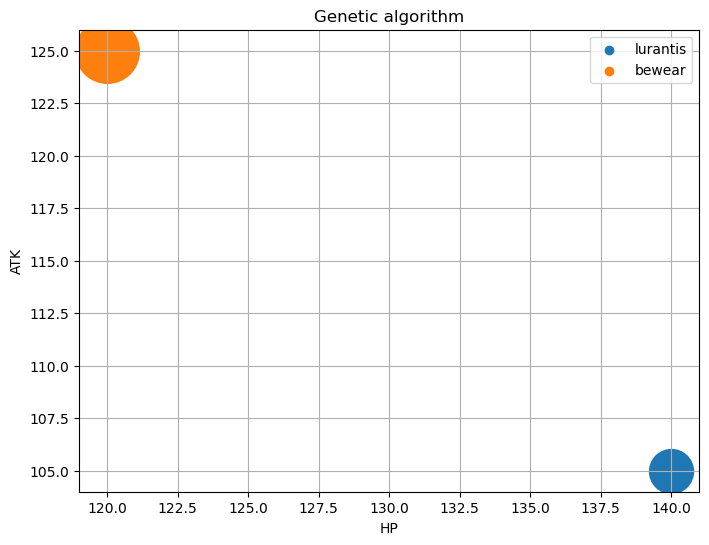

In [51]:
plot_solutions(solutions=set1_solutions, names=set1_closest_pokemon, title="Genetic algorithm")

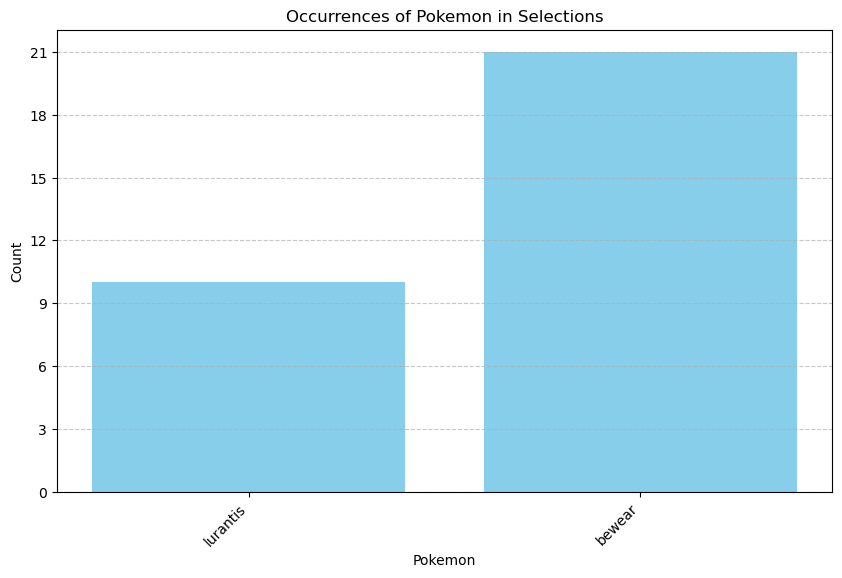

In [52]:
plot_pokemon_counts(pokemon_list=set1_closest_pokemon)

### Pokemon set 2

In [53]:
set2_solutions, set2_closest_pokemon = execute_n_times(df1=pokemon_2, 
                                                       df2=all_enemies_of_pk2, 
                                                       times_to_execute=31, 
                                                       ga_function=regular_ga, 
                                                       seed=69)

Executing run 1/31
Executing run 2/31
Executing run 3/31
Executing run 4/31
Executing run 5/31
Executing run 6/31
Executing run 7/31
Executing run 8/31
Executing run 9/31
Executing run 10/31
Executing run 11/31
Executing run 12/31
Executing run 13/31
Executing run 14/31
Executing run 15/31
Executing run 16/31
Executing run 17/31
Executing run 18/31
Executing run 19/31
Executing run 20/31
Executing run 21/31
Executing run 22/31
Executing run 23/31
Executing run 24/31
Executing run 25/31
Executing run 26/31
Executing run 27/31
Executing run 28/31
Executing run 29/31
Executing run 30/31
Executing run 31/31


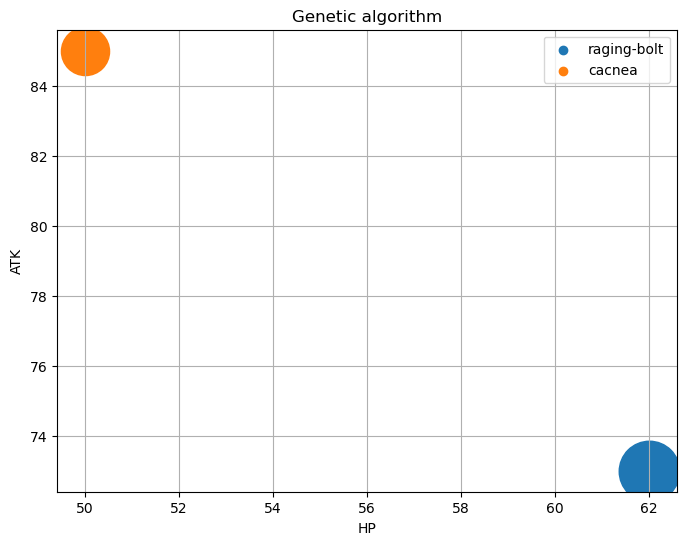

In [54]:
plot_solutions(solutions=set2_solutions, names=set2_closest_pokemon, title="Genetic algorithm")

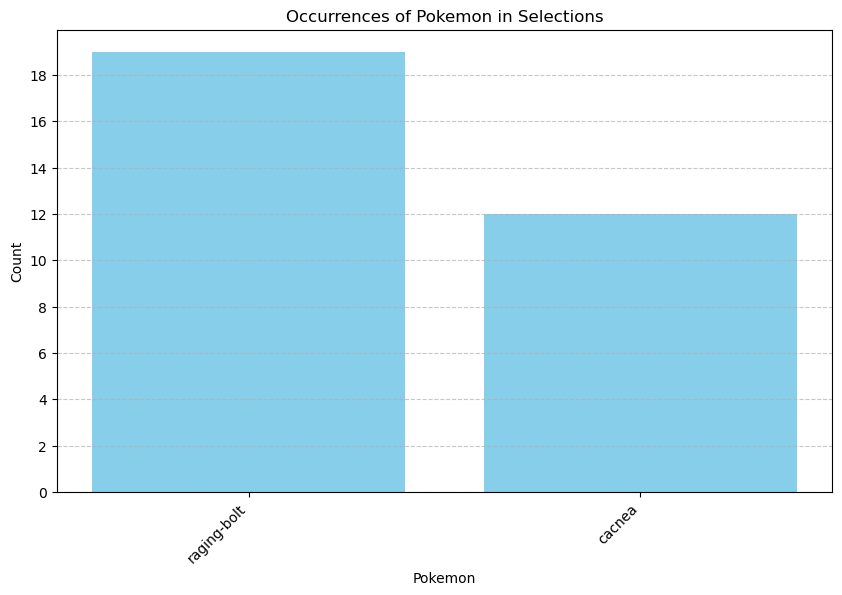

In [55]:
plot_pokemon_counts(pokemon_list=set2_closest_pokemon)

### Pokemon set 3

In [56]:
set3_solutions, set3_closest_pokemon = execute_n_times(df1=pokemon_3, 
                                                       df2=all_enemies_of_pk3, 
                                                       times_to_execute=31, 
                                                       ga_function=regular_ga, 
                                                       seed=69)

Executing run 1/31
Executing run 2/31
Executing run 3/31
Executing run 4/31
Executing run 5/31
Executing run 6/31
Executing run 7/31
Executing run 8/31
Executing run 9/31
Executing run 10/31
Executing run 11/31
Executing run 12/31
Executing run 13/31
Executing run 14/31
Executing run 15/31
Executing run 16/31
Executing run 17/31
Executing run 18/31
Executing run 19/31
Executing run 20/31
Executing run 21/31
Executing run 22/31
Executing run 23/31
Executing run 24/31
Executing run 25/31
Executing run 26/31
Executing run 27/31
Executing run 28/31
Executing run 29/31
Executing run 30/31
Executing run 31/31


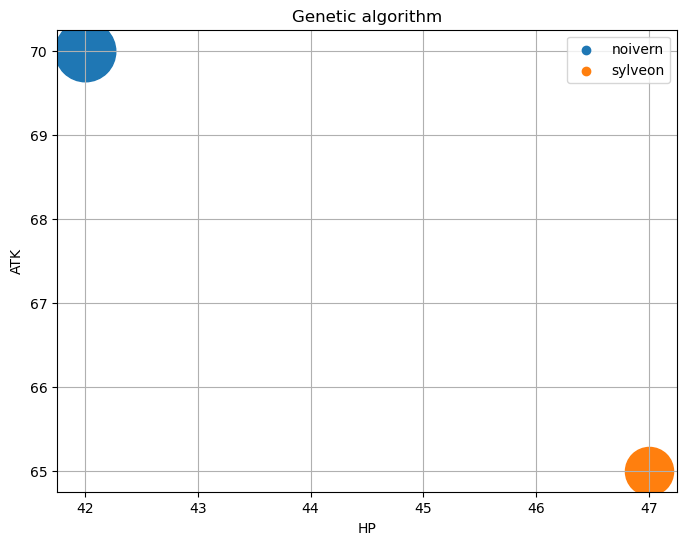

In [57]:
plot_solutions(solutions=set3_solutions, names=set3_closest_pokemon, title="Genetic algorithm")

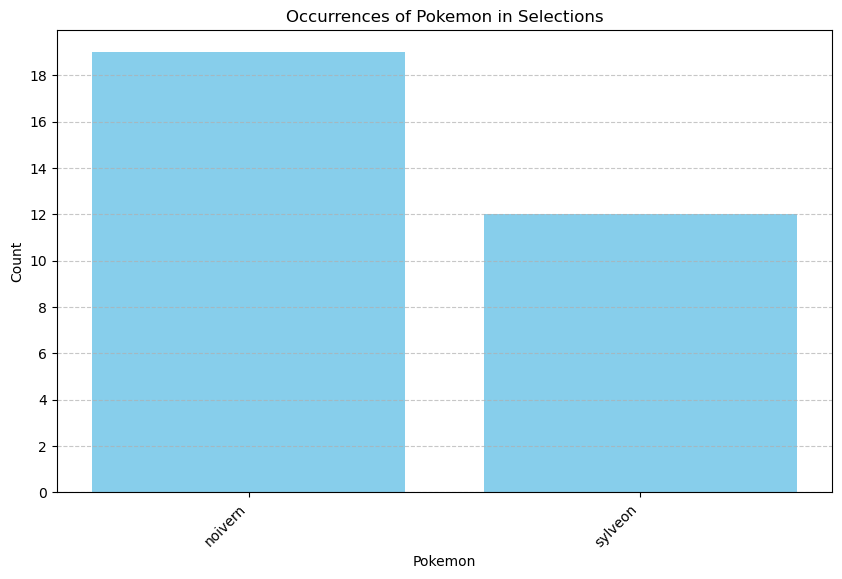

In [58]:
plot_pokemon_counts(pokemon_list=set3_closest_pokemon)

# Genetic algorithm with Monte Carlo

In [59]:
def ga_with_mc(df1:DataFrame, df2:DataFrame, seed:int=42, num_simulations:int=100) -> tuple[list, list]:
    """
    Regular genetic algorithm (GA) function that predicts best Pokemons against df1 based on df2

    Args:
    - df1 (DataFrame): Single Pokemon on which GA will run
    - df2 (DataFrame): Set of all Pokemon with adjusted HP and attack
    - seed (int, optional): Seed to use. Defaults to 42.
    - num_simulations (int, optional): Number of simulations to use with Monte Carlo . Defaults to 100.

    Returns (list, list):
    - best_solution: results of GA in numeric form
    - closest_pokemon: names of the closest Pokemon (instead of numbers)

    Example:
    ```
    ga_with_mc(df1.selectExpr("id","name","type1", "CAST(hp AS INT) AS hp", "CAST(atk AS INT) AS atk"), 
                df2.selectExpr("id","name","type1", "CAST(hp AS INT) AS hp", "CAST(atk AS INT) AS atk"),
                seed=42
    )
    ```
    """
    
    # Used in fitness_function, 10x faster if moved out
    target_stats = df1.select(F.sum("hp") + F.sum("atk")).collect()[0][0]
    
    # Used in create_population, a bit faster if moved out
    population = df2.select("hp", "atk").collect()
    
    def fitness_function(ga_instance, solution, solution_idx):
        """
        Fitness function to evaluate the strength of a Pokemon.
        Here, we use Monte Carlo simulations to estimate the fitness.
        """
        total_stats = solution[0] + solution[1]  # hp + atk
        # Perform Monte Carlo simulations to estimate fitness
        return monte_carlo_simulation(total_stats, target_stats, num_simulations)

    def create_population():
        """
        Create initial population by randomly selecting Pokemon from df2.
        """
        return [[float(p.hp), float(p.atk)] for p in population]

    # Initialize genetic algorithm without mutation
    ga = GA(num_generations=100,
            num_parents_mating=2,
            fitness_func=fitness_function,
            sol_per_pop=10,
            num_genes=2,
            gene_type=float,
            initial_population=create_population(),
            parent_selection_type="sss",
            crossover_type="single_point",
            mutation_type=None)  # Disable mutation

    # Set seed for the genetic algorithm instance
    set_seed(seed)
    ga.seed = seed

    # Run genetic algorithm
    ga.run()

    # Get the final best solution
    best_solution = ga.best_solution()

    # Find the Pokemon closest to the best solution
    target_stats = np.array(best_solution[0])
    df2_stats = np.array(df2.select("hp", "atk").collect())
    distances = np.linalg.norm(df2_stats - target_stats, axis=1)
    closest_pokemon_idx = np.argmin(distances)
    closest_pokemon = df2.select("name").collect()[closest_pokemon_idx][0]

    # print("Best Solution:", best_solution)
    # print("Closest Pokemon to Solution:", closest_pokemon)
    
    return best_solution, closest_pokemon

def monte_carlo_simulation(total_stats: int, target_stats: int, num_simulations: int) -> float:
    """
    Perform Monte Carlo simulations to estimate the fitness
    
    Args:
    - total_stats (int): HP and attack combined
    - target_stats (int): stats of Pokemon to defeat
    - num_simulations (int): number of simulations to run

    Returns (float):
    - avg fitness: total_fitness / num_simulations

    Example:
    ```
    monte_carlo_simulation(41, 24, 100)
    ```
    """
    
    total_fitness = 0
    
    for _ in range(num_simulations):
        # Generate random perturbation around total_stats
        perturbation = np.random.normal(loc=0, scale=0.1, size=1)[0]
        simulated_stats = total_stats + perturbation
        # Evaluate fitness based on the difference between simulated_stats and target_stats
        total_fitness += 1 / (abs(simulated_stats - target_stats) + 0.0001)  # Avoid division by zero
    
    # Average fitness over simulations
    return total_fitness / num_simulations

### Pokemon set 1

In [60]:
set1_solutions, set1_closest_pokemon = execute_n_times(df1=pokemon_1, 
                                                       df2=all_enemies_of_pk1, 
                                                       times_to_execute=31, 
                                                       ga_function=ga_with_mc, 
                                                       seed=69)

Executing run 1/31
Executing run 2/31
Executing run 3/31
Executing run 4/31
Executing run 5/31
Executing run 6/31
Executing run 7/31
Executing run 8/31
Executing run 9/31
Executing run 10/31
Executing run 11/31
Executing run 12/31
Executing run 13/31
Executing run 14/31
Executing run 15/31
Executing run 16/31
Executing run 17/31
Executing run 18/31
Executing run 19/31
Executing run 20/31
Executing run 21/31
Executing run 22/31
Executing run 23/31
Executing run 24/31
Executing run 25/31
Executing run 26/31
Executing run 27/31
Executing run 28/31
Executing run 29/31
Executing run 30/31
Executing run 31/31


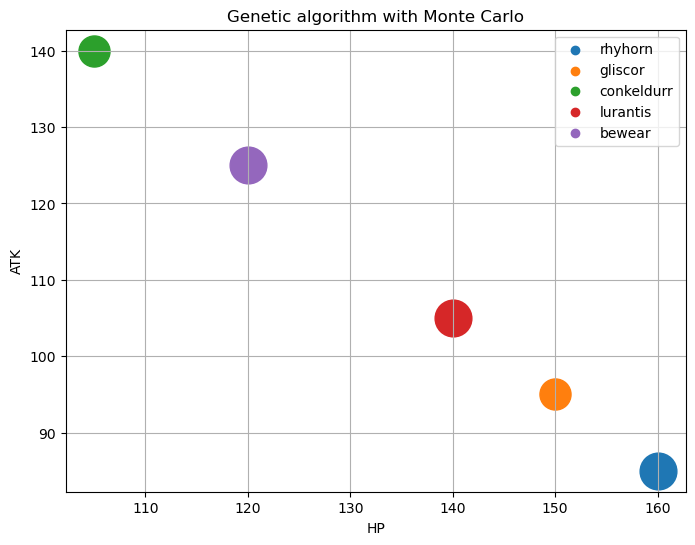

In [61]:
plot_solutions(solutions=set1_solutions, names=set1_closest_pokemon, title="Genetic algorithm with Monte Carlo")

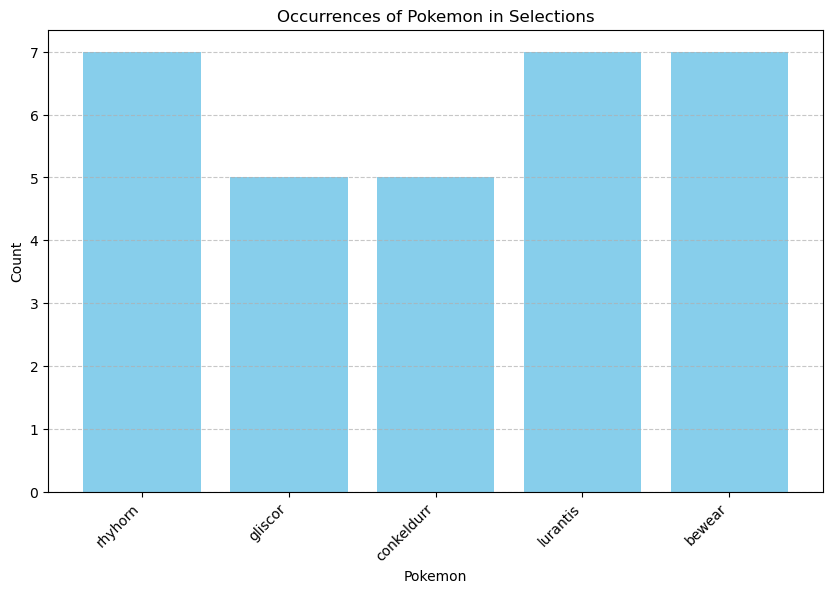

In [62]:
plot_pokemon_counts(pokemon_list=set1_closest_pokemon)

### Pokemon set 2

In [63]:
set2_solutions, set2_closest_pokemon = execute_n_times(df1=pokemon_2, 
                                                       df2=all_enemies_of_pk2, 
                                                       times_to_execute=31, 
                                                       ga_function=ga_with_mc, 
                                                       seed=69)

Executing run 1/31
Executing run 2/31
Executing run 3/31
Executing run 4/31
Executing run 5/31
Executing run 6/31
Executing run 7/31
Executing run 8/31
Executing run 9/31
Executing run 10/31
Executing run 11/31
Executing run 12/31
Executing run 13/31
Executing run 14/31
Executing run 15/31
Executing run 16/31
Executing run 17/31
Executing run 18/31
Executing run 19/31
Executing run 20/31
Executing run 21/31
Executing run 22/31
Executing run 23/31
Executing run 24/31
Executing run 25/31
Executing run 26/31
Executing run 27/31
Executing run 28/31
Executing run 29/31
Executing run 30/31
Executing run 31/31


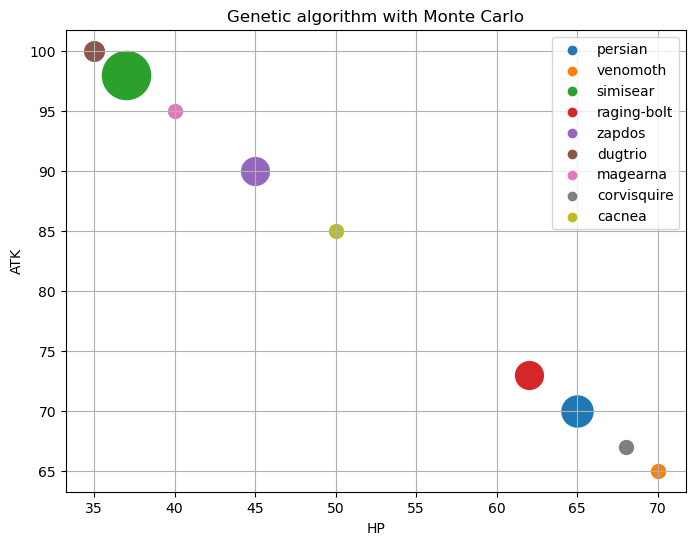

In [64]:
plot_solutions(solutions=set2_solutions, names=set2_closest_pokemon, title="Genetic algorithm with Monte Carlo")

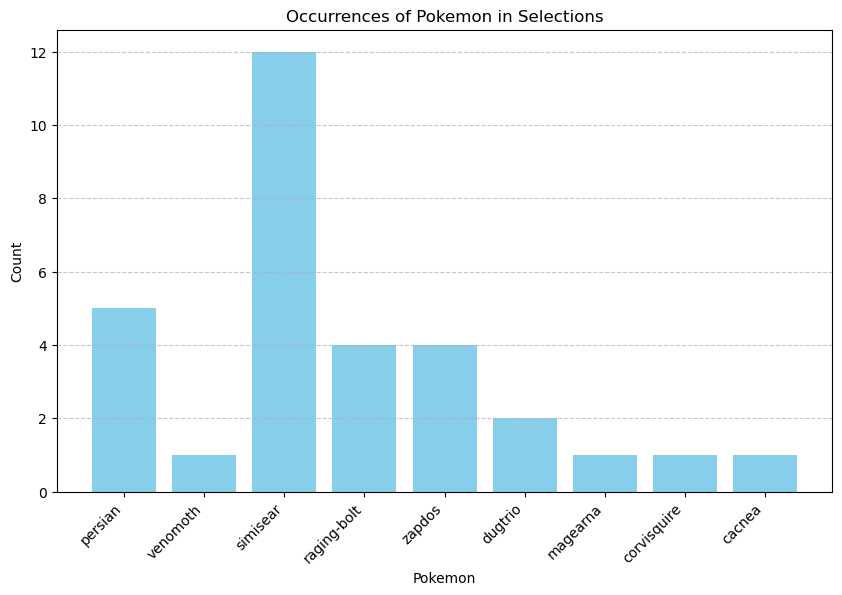

In [65]:
plot_pokemon_counts(pokemon_list=set2_closest_pokemon)

### Pokemon set 3

In [66]:
set3_solutions, set3_closest_pokemon = execute_n_times(df1=pokemon_3,
                                                       df2=all_enemies_of_pk3, 
                                                       times_to_execute=31, 
                                                       ga_function=ga_with_mc, 
                                                       seed=69)

Executing run 1/31
Executing run 2/31
Executing run 3/31
Executing run 4/31
Executing run 5/31
Executing run 6/31
Executing run 7/31
Executing run 8/31
Executing run 9/31
Executing run 10/31
Executing run 11/31
Executing run 12/31
Executing run 13/31
Executing run 14/31
Executing run 15/31
Executing run 16/31
Executing run 17/31
Executing run 18/31
Executing run 19/31
Executing run 20/31
Executing run 21/31
Executing run 22/31
Executing run 23/31
Executing run 24/31
Executing run 25/31
Executing run 26/31
Executing run 27/31
Executing run 28/31
Executing run 29/31
Executing run 30/31
Executing run 31/31


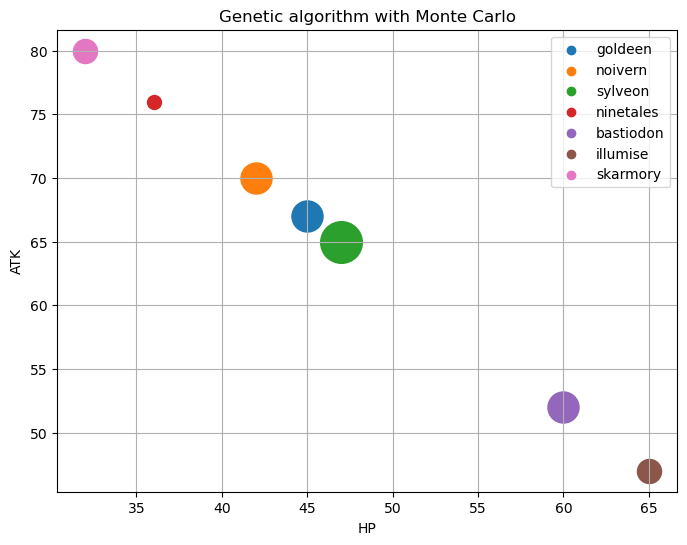

In [67]:
plot_solutions(solutions=set3_solutions, names=set3_closest_pokemon, title="Genetic algorithm with Monte Carlo")

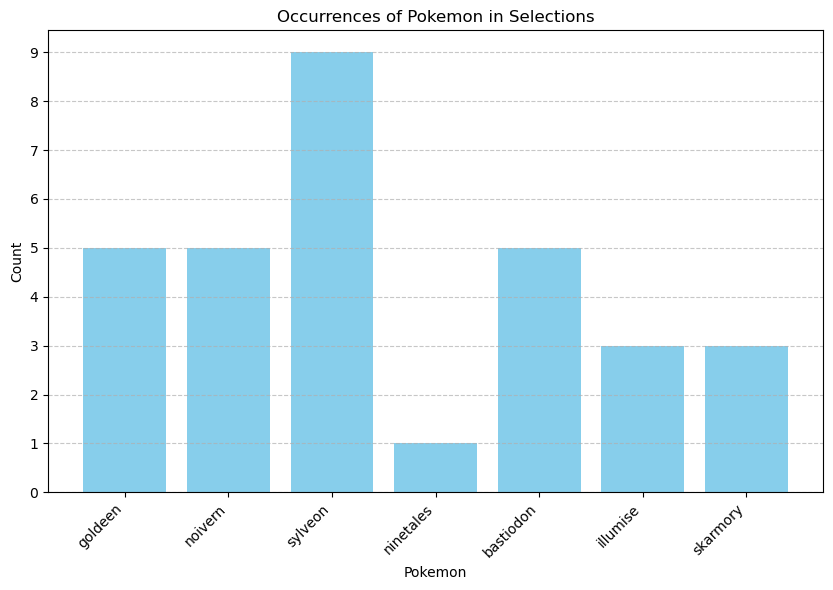

In [68]:
plot_pokemon_counts(pokemon_list=set3_closest_pokemon)

# Algorithm 3

In [69]:
# Some code, tbd

# Testing

In [70]:
# Here is temp code!